# Final Project 2021 - Leonardo Serilli( mat. 274426)
## Dreaming
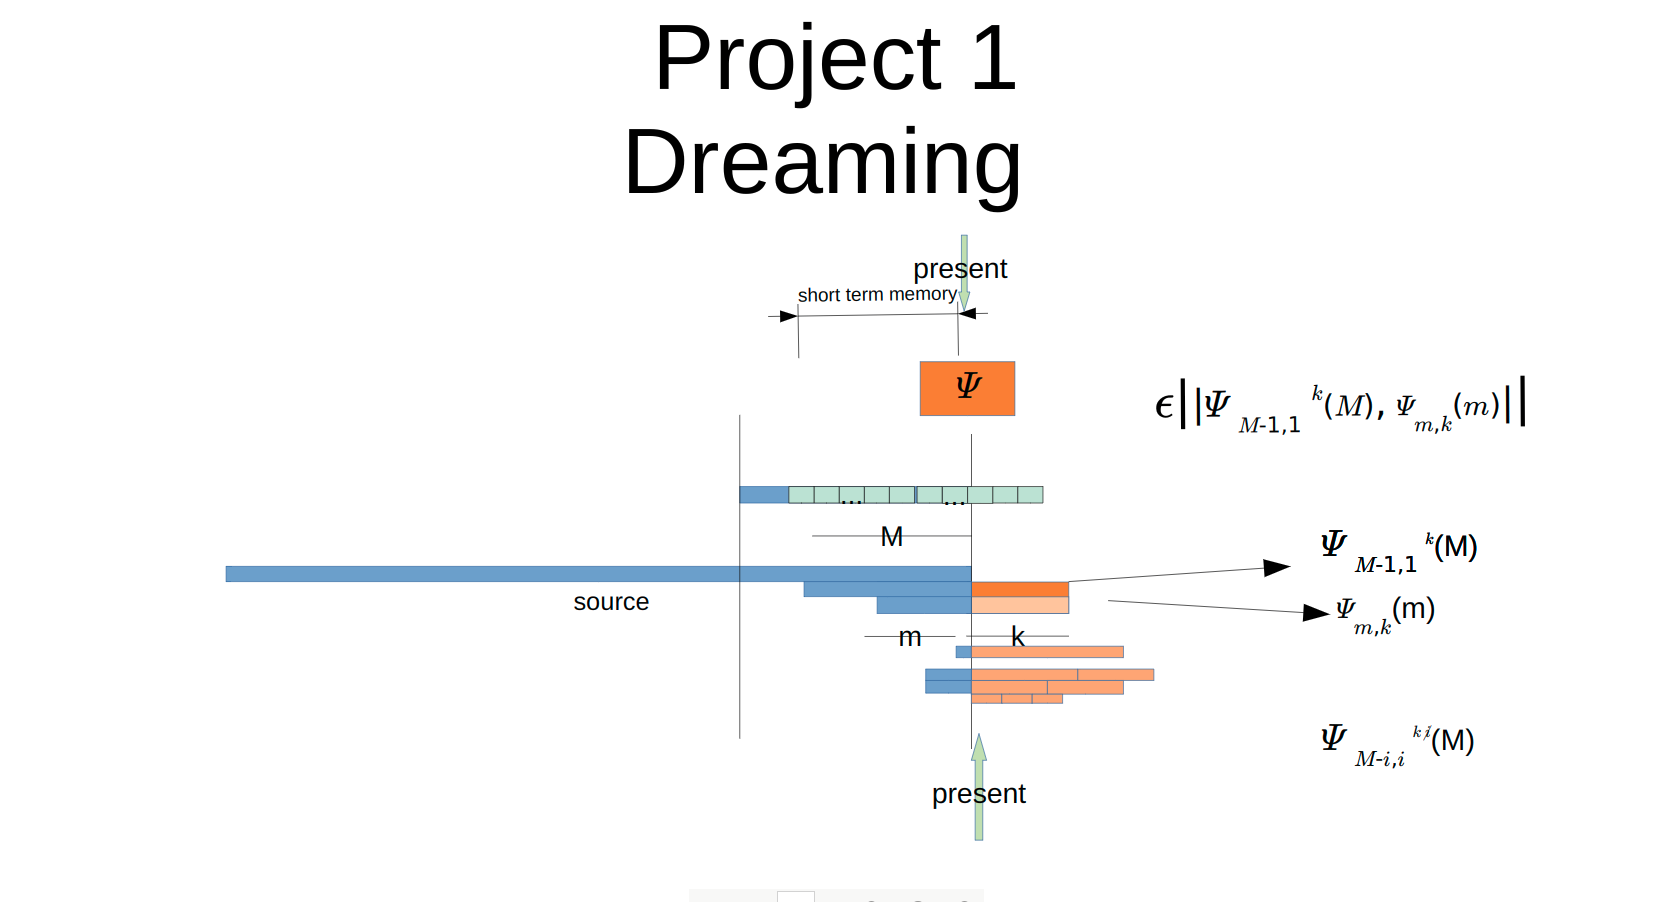
Lo scopo del progetto riguarda l'implementazione di **due modelli** in grado di **predirre i successivi valori di una sequenza**.

Nel seguente codice è utilizzato un dataset contenenti i primi **1000 numeri della sequenza di fibonacci**.
Data una **window di taglia M** sono implementati due modelli:

   **(1) SingleOut_model**: questo, presa in input una sequenza di M-1 valori, predice l'M-esimo.

   **(2) MultiOut_model**: quest altro invece, presa in input una sequenza di M/2 valori, predice i prossimi M/2


I due modelli hanno la stessa capacità, poichè il SingleOut_model, tramite uno **slide della window** può predirre lo stesso numero di valori predetti dal multiOut_model.


In [3]:
import pandas as pd
import copy as cp
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [4]:
# normalizza un valore rispetto al maggior valore del dataset
def normalize(val, normalizer):
    new_val = val/normalizer
    return new_val

## Dataset
La funzione **get_dataset()** manipola il dataset in modo che, ogni sample, composto **nizialmente di un solo valore**, dopo la chiamata conterrà **anche gli M-1 valori successivi**, come mostrato nelle seguente immagine:

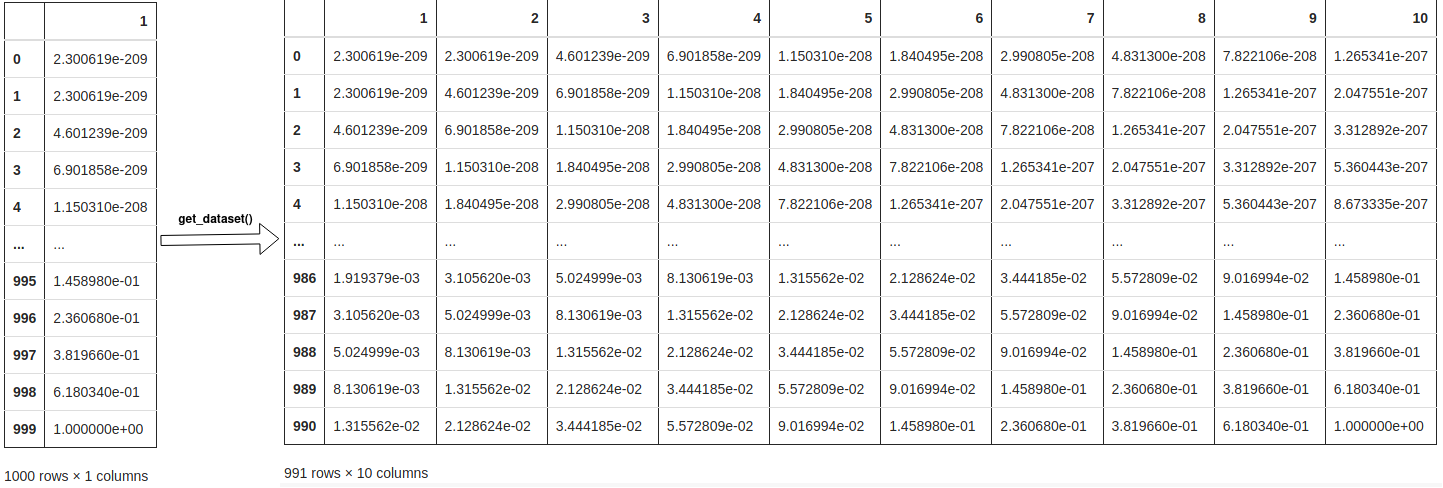

In [5]:
# ritorna un dataset strutturato in cui ogni sample contiene una parte della sequenza di fibonacci di dimensioni pari alla window
def get_dataset(dataset, window):
    data = cp.deepcopy(dataset)
    for i in range (2, window+1):
        new_col = [data[i-1][j] for j in range(1, len(data[i-1]))]
        data = data.iloc[:len(data[i-1])-1,]
        data.loc[: ,i] = new_col
    return data

## Inilizializzazione
Nella box sottostante:

**(1)** viene definita la **dimensione della window** utlizzata dai modelli;

**(2)** i valori del dataset vengono **normalizzati tra 0 e 1**;

**(3)** viene **ampliato il dataset** tramite la funzione **get_dataset()** descritta precedentemente;

In [6]:
window = 10

dataset = pd.read_csv('fibo.txt', sep=",", header=None, usecols=[1]).iloc[0:1000, :] # lettura del dataset
data = dataset.apply(pd.to_numeric, errors='coerce') # converte in interi i numeri di fibonacci del dataset

# normalizza i valori del dataset dividendo tutti i numeri di fibonacci per il più grande tra di loro
normalizer = data.iloc[len(data[1])-1, data.columns.get_loc(1)]
for i in range(len(data[1])):
    val = data.iloc[i, data.columns.get_loc(1)]
    data.iloc[i, data.columns.get_loc(1)] = normalize(val, normalizer)

# creazione del dataset per entrambi i modelli
df = get_dataset(data, window)

# Modello
Il modello utilizzato è lo stesso per entrambi i tipi di predizione, la differenza tra i due sta nel **numero di input e di output**.

In [7]:
# ritorna un modello per n_inputs input e n_outputs output
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

## Multi output model
Il modello lavora su dataset composti da **M/2 input** per predirre gli **M/2 valori successivi** rappresentanti nell'**output**. 
Gli insiemi di Train e test sono creati seguendo tale schema nella funzione **get_multiOut_train_test()**

Dopo la creazione di questi il modello è **allenato e testato** sui rispettivi insiemi.

Lo score del testing è rappresentato tramite il **Minimo Errore Assoluto (MAE)** sulle predizioni.

L'esempio mostrato nell'ultima box prdice i **valori di fibonacci(n)** per n che va **da 9 a 13**;
i valori sono scelti in modo da ottenere gli stessi valori ottenuti successivamente nell'esempio del **singleOutput_model**.

In [8]:
# ritorna train e test set per il modello multi-output, in cui la prima metà delle feature sono considerate input e l'altra metà output
def get_multiOut_train_test(dataset, window):
    data = cp.deepcopy(dataset)
    x = data.iloc[:, 0:window//2]
    y = data.iloc[:, window//2:]
    return train_test_split(x, y, test_size=0.2, train_size=0.8)

In [9]:
# creazione di train e test set per il multi output model
TS_x_multiOut, tst_x_multiOut, TS_y_multiOut, tst_y_multiOut = get_multiOut_train_test(df, window)

# creazione e fit del multi output model
multiOut_model = get_model(len(TS_x_multiOut.columns),len(TS_y_multiOut.columns))
multiOut_model.fit(TS_x_multiOut, TS_y_multiOut, verbose=0, epochs=100)

# valutazione del multi output model
multiOut_score = multiOut_model.evaluate(tst_x_multiOut, tst_y_multiOut, verbose=0)
print("il minimo errore assoluto(MAE) nel testing è: ", multiOut_score)

il minimo errore assoluto(MAE) nel testing è:  0.0003543794446159154


In [10]:
# dato un sample, grazie allo sliding della finestra, predice ritorna la predizione per i prossimi window/2 valori, cioè lo stesso numero predetto dal multi-output model
def predict_next_window(singleOut_model, x, window):
    for i in range(window//2):
        y = singleOut_model.predict([x])
        x = x[1:]
        x.append(float(y[0]))
    return x[-(window//2):]

In [11]:
# Esempio per il modello multi-output
x = []
for i in range(window//2):
    x.append(int(dataset[1][i+window//2-1]))
y = multiOut_model.predict([x])

print("\ninput: ", x)
print("output: ", y[0])


input:  [5, 8, 13, 21, 34]
output:  [ 53.10469  86.16487 144.63611 233.12753 374.0878 ]


## Single output model
Il modello lavora su dataset composti da **M-1 input** per predirre l'**M-esimo valore** rappresentato nell'**output**. 
Gli insiemi di Train e test sono creati seguendo tale schema nella funzione **get_singleOut_train_test()**

Dopo la creazione di questi il modello è **allenato e testato** sui rispettivi insiemi.

Lo score del testing è rappresentato tramite il **Minimo Errore Assoluto (MAE)** sulle predizioni.

Tramite la predizione **predict_next_window()** vengono predetti gli M/2 valori successivi a quelli presenti nell'input, tramite un meccanismo di sliding che, dopo aver predetto il valore successivo:
<ul>
<li>rimuove il primo valore dell'input;</li>
<li>aggiunge all'inpu il valore predetto;</li>
<li>predice il nuovo valore successivo</li>
</ul>

L'esempio mostrato nell'ultima box prdice i **valori di fibonacci(n)** per  di n che va **da 9 a 13**;
i valori sono scelti in modo da ottenere gli stessi valori ottenuti precedentemente nell'esempio del **multiOutput_model**.

In [12]:
# ritorna train e test set per il modello single-output, in cui l'ultima feature è considerata come output
def get_singleOut_train_test(dataset):
    data = cp.deepcopy(dataset)
    x = data.iloc[:, 0:len(data.columns)-1]
    y = data.iloc[:, len(data.columns)-1:]
    return train_test_split(x, y, test_size=0.2, train_size=0.8)

In [13]:
# creazione di train e test set per il single output model
TS_x_singleOut, tst_x_singleOut, TS_y_singleOut, tst_y_singleOut = get_singleOut_train_test(df)

# creazione e fit del single output model
singleOut_model = get_model(len(TS_x_singleOut.columns),len(TS_y_singleOut.columns))
singleOut_model.fit(TS_x_singleOut, TS_y_singleOut, verbose=0, epochs=100)

# valutazione del multi output model
singleOut_score = singleOut_model.evaluate(tst_x_singleOut, tst_y_singleOut, verbose=0)
print("il minimo errore assoluto(MAE) nel testing è: ", singleOut_score)

il minimo errore assoluto(MAE) nel testing è:  0.0005648580263368785


In [25]:
# dato un sample, grazie allo sliding della finestra, predice ritorna la predizione per i prossimi window/2 valori, cioè lo stesso numero predetto dal multi-output model
def predict_next_window(singleOut_model, x, window):
    out = []

    for i in range(window//2):
        y = singleOut_model.predict([x])
        x = x[1:]
        x.append(float(dataset[1][window-1+i]))
        out.append(float(y[0]))
    return out

In [26]:
# Esempio per il modello single-output
x = []
for i in range(window-1):
    x.append(int(dataset[1][i]))
y = predict_next_window(singleOut_model, x, window)

print("\ninput: ", x)
print("output: ", y)


input:  [1, 1, 2, 3, 5, 8, 13, 21, 34]
output:  [53.84745788574219, 87.27184295654297, 141.1194610595703, 228.39146423339844, 369.5110778808594]


# Conclusioni
Il codice è stato eseguito per una window di dimensione 10, e un dataset dei primi 1000 numeri di fibonacci.
Dallo score dei due modelli ottenuto sul test set si nota come il **multi output model** ottenga un **MAE** maggiore rispetto al **single output Model**
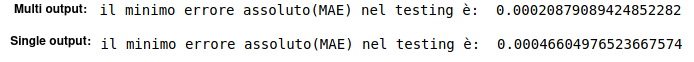

Dai valori predetti nell'esempio invece si nota che, nonostante i valori predetti da entrambi siano **molto vicini tra di loro**, quelli del **multi ouput model si avvicinano di più** al valore effettivo di fibonacci(n) rispetto quelli del single output model

